In [1]:
import os
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import seaborn as sns


In [2]:

# File paths
signal_files_lowX_lowY = [
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y95/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y100/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y125/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y95/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y100/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y125/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y90/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y90/preselection"),
# #     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y95/preselection"),
# #     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y100/preselection"),
]

background_files = [
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt40/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GluGluHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/ttHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/VBFHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/VHToGG/preselection"),
    ## Adding resonant backgrounds
    
]

In [3]:
# Columns to be loaded
keys = [
     'dibjet_pt', 'diphoton_pt', 'bbgg_pt', 'bbgg_eta', 'bbgg_phi',
    'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi', 'diphoton_eta', 
    'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 
    'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 
    'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 'CosThetaStar_jj', 
    'CosThetaStar_CS', 'DeltaR_jg_min',   'pholead_PtOverM', 'phosublead_PtOverM',
    'weight_preselection',
]
# Variables removed :- 'bbgg_mass','FirstJet_PtOverM', 'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass', 'lead_pho_eta',

## Add 

In [4]:
# Load DataFrames
dfs = {}

# Load signal files
for file, key in signal_files_lowX_lowY:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Load background files
for file, key in background_files:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Combine signal DataFrames
signal_df = pd.concat([dfs[key] for key in dfs if 'NMSSM' in key], ignore_index=True)
background_df = pd.concat([dfs[key] for key in dfs if 'GJet' in key or 'GGJets' in key or 'GluGluHToGG' in key or 'ttHToGG' in key
                              or 'VBFHToGG' in key or 'VHToGG' in key ], ignore_index=True)



# signal_df = pd.concat([])
# Print combined sample sizes
print(f'Total Signal Shape: {signal_df.shape}')
print(f'Total Background Shape: {background_df.shape}')


Total Signal Shape: (135416, 27)
Total Background Shape: (836887, 27)


In [5]:
# Assign labels to signal and background classes
signal_df['label'] = 0  # Signal class

# Assign background labels based on the key
dfs["/GGJets/preselection"]['label'] = 1  # Background class 1
dfs["/GJetPt20To40/preselection"]['label'] = 2  # Background class 2
dfs["/GJetPt40/preselection"]['label'] = 2  # Background class 2
dfs["/GluGluHToGG/preselection"]['label'] = 3  # Background class 3
dfs["/ttHToGG/preselection"]['label'] = 4  # Background class 4
dfs["/VBFHToGG/preselection"]['label'] = 5  # Background class 5
dfs["/VHToGG/preselection"]['label'] = 6  # Background class 6

# Combine signal and all background dataframes into one DataFrame
combined_df = pd.concat([signal_df, dfs["/GGJets/preselection"], dfs["/GJetPt20To40/preselection"], dfs["/GJetPt40/preselection"], dfs["/GluGluHToGG/preselection"], 
                        dfs["/ttHToGG/preselection"], dfs["/VBFHToGG/preselection"], dfs["/VHToGG/preselection"]], ignore_index=True)


In [6]:
combined_df

,dibjet_pt,diphoton_pt,bbgg_pt,bbgg_eta,bbgg_phi,lead_pho_phi,sublead_pho_eta,sublead_pho_phi,diphoton_eta,diphoton_phi,...,sublead_bjet_PNetB,lead_bjet_PNetB,CosThetaStar_gg,CosThetaStar_jj,CosThetaStar_CS,DeltaR_jg_min,pholead_PtOverM,phosublead_PtOverM,weight_preselection,label
0,273.394456,294.997326,23.487851,-3.458779,2.626882,2.980469,-0.900269,3.083984,-0.350339,3.014320,...,0.998047,0.993652,0.853602,-0.031807,0.249639,2.802547,1.589322,0.772765,0.352718,0
1,253.552927,225.293827,29.769215,-3.910366,1.176019,-1.973633,-1.223877,-1.266113,-1.696160,-1.625529,...,0.998535,0.976562,-0.535180,0.775318,-0.478706,2.678131,1.017722,0.987015,0.352718,0
2,104.400075,180.932028,247.974662,-1.219801,0.360902,0.246521,-0.602295,-1.188965,-1.017446,-0.019204,...,0.006382,0.257080,-0.473878,-0.807316,-0.006951,0.690966,1.373575,0.391799,0.352718,0
3,191.604827,295.489810,127.108311,-1.009758,0.359729,0.134399,-0.505371,-0.595215,-0.808987,-0.116548,...,0.993164,0.998535,-0.551963,0.974940,-0.624483,2.622470,1.673362,0.902163,0.352718,0
4,270.115922,299.517799,164.759707,-0.909104,2.530558,-2.942871,0.468506,-2.334473,0.222130,-2.642711,...,0.999023,0.999512,-0.651835,0.772105,0.477191,2.342582,1.270696,1.238417,0.352718,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972298,86.357074,71.403774,18.546033,0.753523,1.433836,3.065918,0.249451,-1.111572,0.415031,-2.413949,...,0.011841,0.008347,-0.015983,-0.086373,0.265971,0.927649,0.665747,0.496908,-0.000346,6
972299,66.353453,95.380334,154.966727,0.500964,-1.028900,-1.545410,0.236053,0.720093,1.156215,-1.269603,...,0.178223,0.035339,0.522694,0.983205,0.965841,0.934970,0.933776,0.278357,0.000346,6
972300,65.640100,80.490415,34.340037,3.340366,0.227474,-0.220642,0.444580,-1.399170,2.105769,-0.692458,...,0.037170,0.006916,0.878269,0.447392,0.420146,0.596937,0.472248,0.330551,0.000346,6
972301,107.506290,111.292782,52.436570,-1.874503,0.579677,-1.050293,-0.665527,0.784668,-1.447335,-0.679540,...,0.002909,0.003834,-0.552172,-0.919797,-0.786708,0.977508,0.967483,0.352536,-0.000346,6


In [7]:
# # Combine signal and background data
# combined_df = pd.concat([signal_df, background_df], ignore_index=True)
# print(f'Combined DataFrame Shape: {combined_df.shape}')

# Define features and labels
features = [
    'bbgg_eta', 'bbgg_phi', 'lead_pho_phi', 'sublead_pho_eta', 
    'sublead_pho_phi', 'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 
    'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 
    'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 
    'phosublead_PtOverM'
]

# variables removed:  'bbgg_mass',  'lead_pho_eta','FirstJet_PtOverM', 'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass'

In [8]:

X = combined_df[features]
y = combined_df['label']
weights = combined_df['weight_preselection']

# Impute missing values and scale the data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Extract weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [9]:
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [10]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available.
Device name: Tesla T4


## Multiclassification 

In [11]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
# from scipy import interp  # interp is deprecated in newer scipy versions

# Ensure you're using the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define your enhanced DNN model for multiclass classification
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EnhancedDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 16)
        self.bn5 = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, num_classes)  # Output layer for num_classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Apply Softmax for multiclass classification

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.softmax(self.output(x))  # Output probabilities
        return x

Using device: cuda


In [12]:

# Function to calculate accuracy for multiclass classification
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()  # Compare with true labels
    accuracy = correct / labels.size(0)  # Compute accuracy
    return accuracy

# Assuming X_train, y_train, X_test, y_test are already defined
# and train_loader, test_loader are your DataLoader instances

# Initialize the model
input_dim = X_train.shape[1]  # Assuming X_train is your training data
num_classes = 7  # Example number of classes
model = EnhancedDNN(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass classification
optimizer = Adam(model.parameters(), lr=0.001)

# Use mixed precision for faster training
scaler = torch.cuda.amp.GradScaler()

In [ ]:



# To store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
epochs = 200  # Increased epochs for better training
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for X_batch, y_batch, weight_batch in train_loader:  # Assuming train_loader is your DataLoader
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, y_batch).item()

    # Average training accuracy and loss
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for X_batch, y_batch, weight_batch in test_loader:  # Assuming test_loader is your DataLoader
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()

            with torch.cuda.amp.autocast():
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
            
            test_loss += loss.item()
            test_outputs.append(outputs.cpu())
            test_labels.append(y_batch.cpu())
    
    # Combine lists into tensors for accuracy calculation
    test_outputs = torch.cat(test_outputs)
    test_labels = torch.cat(test_labels)
    
    # Calculate test accuracy
    test_accuracy = calculate_accuracy(test_outputs, test_labels).item()

    # Append test losses and accuracies
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

# Save the model
torch.save(model.state_dict(), 'enhanced_dnn_model.pth')
print("Model saved to 'enhanced_dnn_model.pth'")


Epoch 1/200, Train Loss: 1.6065, Train Accuracy: 0.5526, Test Loss: 1.5853, Test Accuracy: 0.5741
Epoch 2/200, Train Loss: 1.5960, Train Accuracy: 0.5624, Test Loss: 1.5785, Test Accuracy: 0.5814
Epoch 3/200, Train Loss: 1.5915, Train Accuracy: 0.5672, Test Loss: 1.5770, Test Accuracy: 0.5823
Epoch 4/200, Train Loss: 1.5894, Train Accuracy: 0.5694, Test Loss: 1.5745, Test Accuracy: 0.5855
Epoch 5/200, Train Loss: 1.5875, Train Accuracy: 0.5714, Test Loss: 1.5743, Test Accuracy: 0.5846


In [16]:
## Load the saved model
# Initialize the model
model = EnhancedDNN(input_dim, num_classes)

# Load the saved model parameters
model.load_state_dict(torch.load('modelFile/enhanced_dnn_model.pth'))

# Set the model to evaluation mode
model.eval()

# Now you can use the model for inference or testing


EnhancedDNN(
  (fc1): Linear(in_features=23, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=32, out_features=16, bias=True)
  (bn5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=16, out_features=7, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

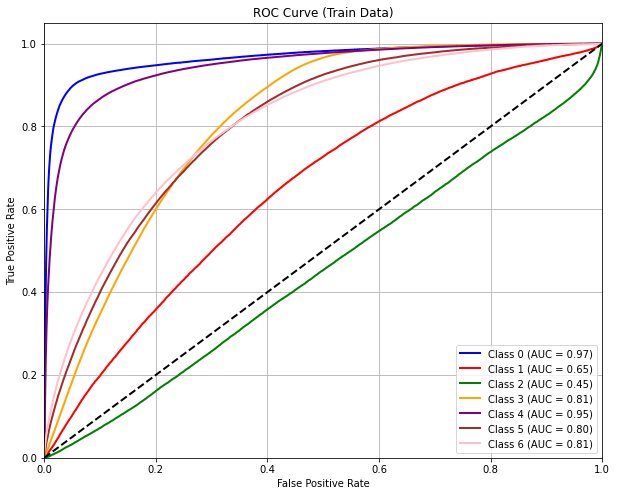

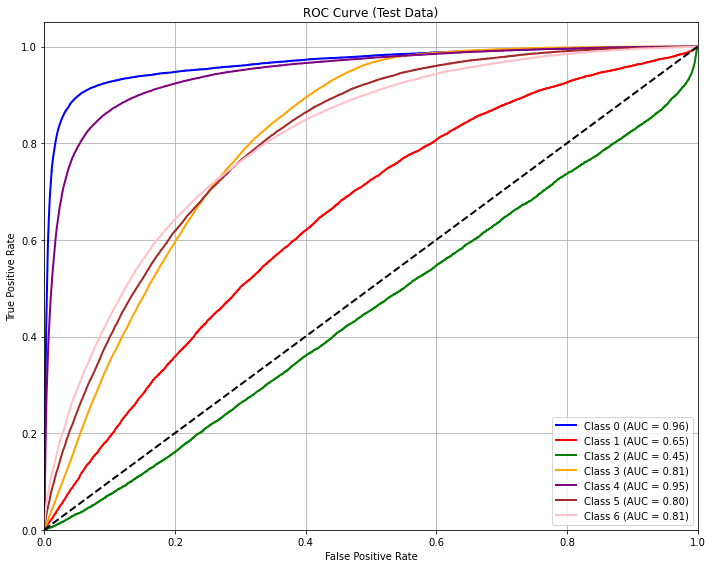

In [22]:

# Collect true labels and predictions for ROC curve calculation
train_true = []
train_preds = []
test_true = []
test_preds = []

model.eval()
with torch.no_grad():
    # Collect predictions and true labels for training data
    for X_batch, y_batch, weight_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()
        outputs = model(X_batch)
        train_preds.append(outputs.cpu().numpy())
        train_true.append(y_batch.cpu().numpy())
    
    # Collect predictions and true labels for test data
    for X_batch, y_batch, weight_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()
        outputs = model(X_batch)
        test_preds.append(outputs.cpu().numpy())
        test_true.append(y_batch.cpu().numpy())

# Convert lists to numpy arrays for binarization and ROC calculation
train_true = np.concatenate(train_true)
train_preds = np.concatenate(train_preds)
test_true = np.concatenate(test_true)
test_preds = np.concatenate(test_preds)

# Binarize the output for multiclass classification
y_train_bin = label_binarize(train_true, classes=list(range(num_classes)))
y_test_bin = label_binarize(test_true, classes=list(range(num_classes)))

# Compute ROC curve and ROC area for each class for training data
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(num_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], train_preds[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute ROC curve and ROC area for each class for test data
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], test_preds[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC curves
def plot_roc_multiclass(fpr, tpr, roc_auc, title, num_classes):
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

# Plot the ROC curves for training data
plot_roc_multiclass(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train Data)', num_classes)

# Plot the ROC curves for test data
plot_roc_multiclass(fpr_test, tpr_test, roc_auc_test, 'ROC Curve (Test Data)', num_classes)

plt.tight_layout()
plt.show()


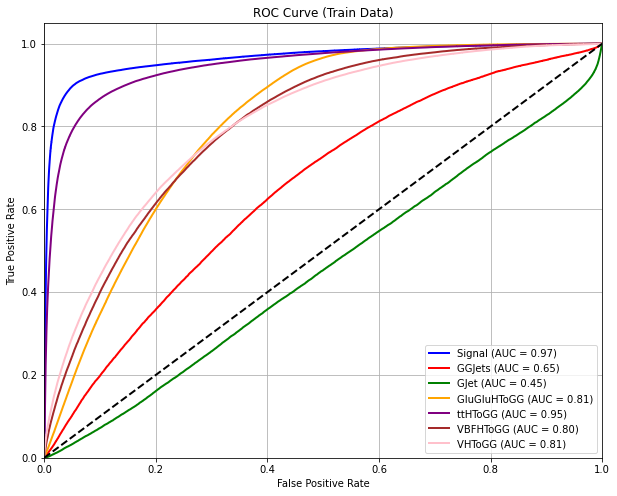

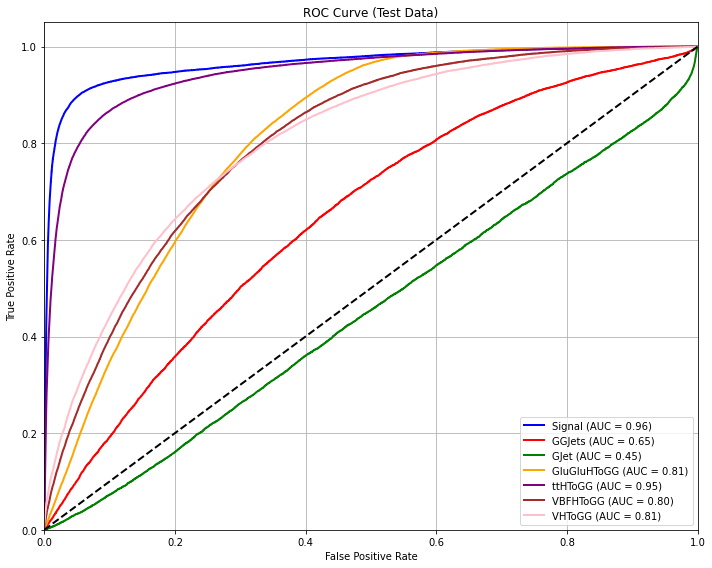

In [24]:
## Updated ROC curves with dataset names instead of class names 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Collect true labels and predictions for ROC curve calculation
train_true = []
train_preds = []
test_true = []
test_preds = []

model.eval()
with torch.no_grad():
    # Collect predictions and true labels for training data
    for X_batch, y_batch, weight_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()
        outputs = model(X_batch)
        train_preds.append(outputs.cpu().numpy())
        train_true.append(y_batch.cpu().numpy())
    
    # Collect predictions and true labels for test data
    for X_batch, y_batch, weight_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).long()
        outputs = model(X_batch)
        test_preds.append(outputs.cpu().numpy())
        test_true.append(y_batch.cpu().numpy())

# Convert lists to numpy arrays for binarization and ROC calculation
train_true = np.concatenate(train_true)
train_preds = np.concatenate(train_preds)
test_true = np.concatenate(test_true)
test_preds = np.concatenate(test_preds)

# Binarize the output for multiclass classification
y_train_bin = label_binarize(train_true, classes=list(range(num_classes)))
y_test_bin = label_binarize(test_true, classes=list(range(num_classes)))

# Create a mapping of dataset names
dataset_names = {
    0: 'Signal',
    1: 'GGJets',
    2: 'GJet',
    3: 'GluGluHToGG',
    4: 'ttHToGG',
    5: 'VBFHToGG',
    6: 'VHToGG',     # Added color for class 7
}

# Compute ROC curve and ROC area for each class for training data
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(num_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], train_preds[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute ROC curve and ROC area for each class for test data
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], test_preds[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC curves
def plot_roc_multiclass(fpr, tpr, roc_auc, title, num_classes):
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{dataset_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

# Plot the ROC curves for training data
plot_roc_multiclass(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train Data)', num_classes)

# Plot the ROC curves for test data
plot_roc_multiclass(fpr_test, tpr_test, roc_auc_test, 'ROC Curve (Test Data)', num_classes)

plt.tight_layout()
plt.show()


NameError: name 'epochs' is not defined

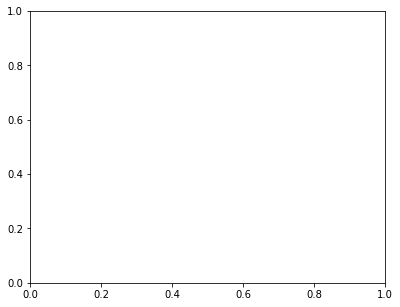

In [17]:
plt.figure(figsize=(14, 5))

# Plot Training and Testing Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

# Plot Training and Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


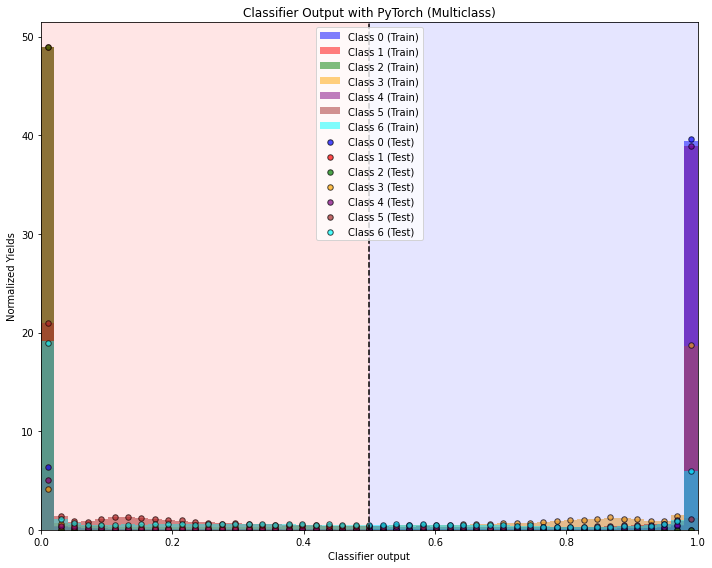

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming the get_predictions function is already defined
def get_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            inputs = inputs.to(device)  # Move inputs to the correct device
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get predictions for training and test data
train_preds, train_true = get_predictions(train_loader, model.to(device), device)
test_preds, test_true = get_predictions(test_loader, model.to(device), device)

# Define bins
bins = np.linspace(0, 1, 50)

plt.figure(figsize=(10, 8))

# Define distinct colors for each class
colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'orange',
    4: 'purple',     # Added color for class 4
    5: 'brown',      # Added color for class 5
    6: 'cyan',       # Added color for class 6
    7: 'magenta'     # Added color for class 7
}

# Plot histograms for training data for each class
for i in range(num_classes):
    color = colors.get(i, 'black')  # Fallback to black if class not found
    class_mask_train = (train_true == i)
    class_preds = train_preds[class_mask_train, i]  # Predictions for class i
    
    # Only plot if there are predictions for the class
    if len(class_preds) > 0:
        plt.hist(class_preds, bins=bins, color=color, alpha=0.5, 
                 label=f'Class {i} (Train)', density=True)

# Calculate bin centers for the scatter plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for test data for each class
for i in range(num_classes):
    color = colors.get(i, 'black')  # Fallback to black if class not found
    class_mask_test = (test_true == i)
    class_preds_test = test_preds[class_mask_test, i]  # Predictions for class i
    
    # Only plot if there are predictions for the class
    if len(class_preds_test) > 0:
        hist_values, _ = np.histogram(class_preds_test, bins=bins, density=True)
        plt.scatter(bin_centers, hist_values, color=color, alpha=0.7, 
                    label=f'Class {i} (Test)', marker='o', s=30, edgecolor='k')

# Add background colors and legend
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend(loc='upper center')
plt.title('Classifier Output with PyTorch (Multiclass)')

# Save and display the plot
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_classifier_output(after_variable_removal).png")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_classifier_output(after_variable_removal).pdf")
plt.tight_layout()
plt.show()


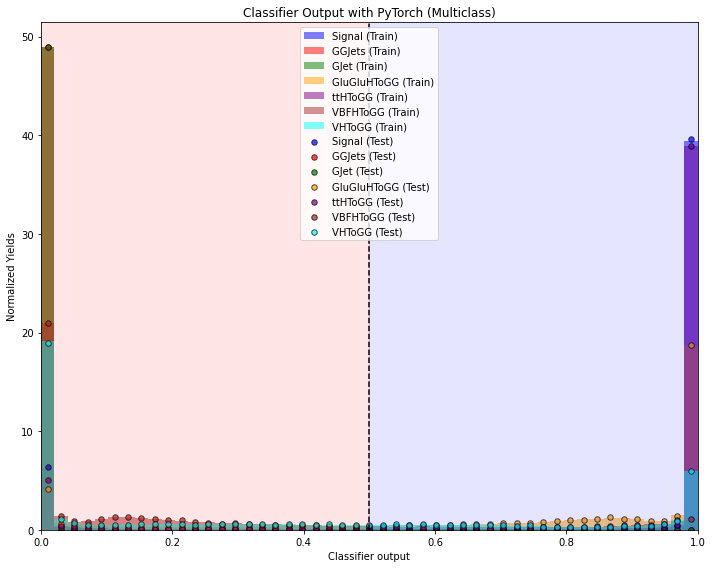

In [21]:
# Assuming the get_predictions function is already defined
def get_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            inputs = inputs.to(device)  # Move inputs to the correct device
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get predictions for training and test data
train_preds, train_true = get_predictions(train_loader, model.to(device), device)
test_preds, test_true = get_predictions(test_loader, model.to(device), device)

# Define bins
bins = np.linspace(0, 1, 50)

plt.figure(figsize=(10, 8))

# Create a mapping of dataset names
dataset_names = {
    0: 'Signal',
    1: 'GGJets',
    2: 'GJet',
    3: 'GluGluHToGG',
    4: 'ttHToGG',
    5: 'VBFHToGG',
    6: 'VHToGG',
}

# Plot histograms for training data for each dataset
for i in range(num_classes):
    color = colors.get(i, 'black')  # Fallback to black if class not found
    class_mask_train = (train_true == i)
    class_preds = train_preds[class_mask_train, i]  # Predictions for class i
    
    # Only plot if there are predictions for the class
    if len(class_preds) > 0:
        plt.hist(class_preds, bins=bins, color=color, alpha=0.5, 
                 label=f'{dataset_names[i]} (Train)', density=True)

# Calculate bin centers for the scatter plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for test data for each dataset
for i in range(num_classes):
    color = colors.get(i, 'black')  # Fallback to black if class not found
    class_mask_test = (test_true == i)
    class_preds_test = test_preds[class_mask_test, i]  # Predictions for class i
    
    # Only plot if there are predictions for the class
    if len(class_preds_test) > 0:
        hist_values, _ = np.histogram(class_preds_test, bins=bins, density=True)
        plt.scatter(bin_centers, hist_values, color=color, alpha=0.7, 
                    label=f'{dataset_names[i]} (Test)', marker='o', s=30, edgecolor='k')

# Add background colors and legend
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend(loc='upper center')
plt.title('Classifier Output with PyTorch (Multiclass)')

# Save and display the plot
plt.tight_layout()
plt.show()


#### Fixing 

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp

# Define your DNN model for multiclass classification
class SimpleDNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, num_classes)  # Output layer for num_classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Apply Softmax for multiclass classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.output(x))  # Output probabilities
        return x

# Function to calculate accuracy for multiclass classification
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()  # Compare with true labels
    accuracy = correct / labels.size(0)  # Compute accuracy
    return accuracy

# Initialize the model
input_dim = X_train.shape[1]  # Assuming X_train is your training data
num_classes = 7  # Example number of classes
model = SimpleDNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass classification
optimizer = Adam(model.parameters(), lr=0.001)

# To store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for X_batch, y_batch, weight_batch in train_loader:  # Assuming train_loader is your DataLoader
        optimizer.zero_grad()
        
        # Cast y_batch to LongTensor
        y_batch = y_batch.long()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, y_batch).item()

    # Average training accuracy and loss
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for X_batch, y_batch, weight_batch in test_loader:  # Assuming test_loader is your DataLoader
            # Cast y_batch to LongTensor for test data
            y_batch = y_batch.long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_outputs.append(outputs.numpy())
            test_labels.append(y_batch.numpy())
    
    # Combine lists into numpy arrays for accuracy calculation
    test_outputs = np.concatenate(test_outputs)
    test_labels = np.concatenate(test_labels)
    
    # Calculate test accuracy
    test_accuracy = calculate_accuracy(torch.tensor(test_outputs), torch.tensor(test_labels)).item()

    # Append test losses and accuracies
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Collect true labels and predictions for ROC curve calculation
train_true = []
train_preds = []
test_true = []
test_preds = []

# During training, collect predictions and true labels
for X_batch, y_batch, weight_batch in train_loader:
    y_batch = y_batch.long()
    outputs = model(X_batch)
    train_preds.append(outputs.detach().numpy())
    train_true.append(y_batch.numpy())

# During testing, collect predictions and true labels
with torch.no_grad():
    for X_batch, y_batch, weight_batch in test_loader:
        y_batch = y_batch.long()
        outputs = model(X_batch)
        test_preds.append(outputs.detach().numpy())
        test_true.append(y_batch.numpy())

# Convert lists to numpy arrays for binarization and ROC calculation
train_true = np.concatenate(train_true)
train_preds = np.concatenate(train_preds)
test_true = np.concatenate(test_true)
test_preds = np.concatenate(test_preds)

# Binarize the output for multiclass classification
y_train_bin = label_binarize(train_true, classes=[i for i in range(num_classes)])
y_test_bin = label_binarize(test_true, classes=[i for i in range(num_classes)])

# Compute ROC curve and ROC area for each class for training data
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(num_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], train_preds[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute ROC curve and ROC area for each class for test data
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], test_preds[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC curves
def plot_roc_multiclass(fpr, tpr, roc_auc, title, num_classes):
    colors = cycle(['blue', 'red', 'green', 'orange'])
    plt.figure()
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

# Plot the ROC curves for training data
plot_roc_multiclass(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train Data)', num_classes)

# Plot the ROC curves for test data
plot_roc_multiclass(fpr_test, tpr_test, roc_auc_test, 'ROC Curve (Test Data)', num_classes)

plt.tight_layout()
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_ROC(after_variable_removal).png")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_ROC(after_variable_removal).pdf")
plt.show()
